# Chocolate rating prediction using random forest, XGBoost, and LightGBM

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import Pool, CatBoostRegressor

In [2]:
# import dataset
df = pd.read_csv("chocolate_train.csv", keep_default_na=False)
test = pd.read_csv("chocolate_test.csv", keep_default_na=False)

In [3]:
#drop unnecessary columns for modelling

df.drop(columns=['Unnamed: 0', 'ref', 'company', 'company_location', 
                 'country_of_bean_origin', 'specific_bean_origin_or_bar_name', 'taste'], inplace=True)
df.head()

,review_date,cocoa_percent,rating,counts_of_ingredients,cocoa_butter,vanilla,lecithin,salt,sugar,sweetener_without_sugar,...,spicy,sour,molasses,woody,vanilla_taste,sticky,fruit,smokey,company_continent,origin_continent
0,3.133333,76.0,3.75,3,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,3.205074,3.218661
1,3.133333,76.0,3.50,3,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,3.205074,3.211669
2,3.133333,76.0,3.25,3,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,3.205074,3.218661
3,3.206944,63.0,3.75,4,1,0,1,0,1,0,...,0,0,0,0,0,0,1,0,3.223531,3.224100
4,3.206944,70.0,3.50,4,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,3.223531,3.224100


In [4]:
test.drop(columns=['Unnamed: 0', 'ref', 'company', 'company_location', 
                 'country_of_bean_origin', 'specific_bean_origin_or_bar_name', 'taste'], inplace=True)
test.head()

,review_date,cocoa_percent,rating,counts_of_ingredients,cocoa_butter,vanilla,lecithin,salt,sugar,sweetener_without_sugar,...,spicy,sour,molasses,woody,vanilla_taste,sticky,fruit,smokey,company_continent,origin_continent
0,3.32,68.0,3.00,3,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,3.205074,3.223404
1,3.32,72.0,3.00,3,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,3.205074,3.224100
2,3.32,80.0,3.25,3,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,3.205074,3.218661
3,3.32,68.0,3.50,3,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,3.205074,3.203216
4,3.32,70.0,4.00,4,1,0,1,0,1,0,...,0,0,0,0,0,0,1,0,3.223531,3.211669


In [5]:
# seperate independent and dependent variables

y = df['rating']
X = df.drop(columns='rating')

y_test = test['rating']
X_test = test.drop(columns='rating')

In [6]:
# models
rf = RandomForestRegressor()
xgb = XGBRegressor()
lg = LGBMRegressor()

In [7]:
# candidate parameters for grid search
rf_param = {'max_depth':range(1, 6, 1), 'n_estimators':[100, 120, 150]}
xgb_param = {'eta':np.arange(0.01, 0.16, 0.02), 'max_depth':range(1, 6, 1), 'n_estimators':[100, 120, 150]}
lg_param = {'learning_rate':np.arange(0.01, 0.16, 0.02), 'max_depth':range(1, 6, 1), 'n_estimators':[100, 120, 150]}

In [8]:
# grid search: best parameter based on MAE
rf_gs = GridSearchCV(rf, rf_param, cv=10, scoring='neg_mean_absolute_error')
xgb_gs = GridSearchCV(xgb, xgb_param, cv=10, scoring='neg_mean_absolute_error')
lg_gs = GridSearchCV(lg, lg_param, cv=10, scoring='neg_mean_absolute_error')

In [9]:
rf_gs.fit(X,y)
rf_gs.best_params_

{'max_depth': 5, 'n_estimators': 120}

In [10]:
xgb_gs.fit(X,y)
rf_gs.best_params_

{'max_depth': 5, 'n_estimators': 120}

In [11]:
lg_gs.fit(X,y)
lg_gs.best_params_

{'learning_rate': 0.10999999999999997, 'max_depth': 2, 'n_estimators': 150}

In [12]:
# use the parameters we just found

final_rf = RandomForestRegressor(max_depth = rf_gs.best_params_['max_depth'], 
                                 n_estimators=rf_gs.best_params_['n_estimators'])
final_xgb = XGBRegressor(eta = xgb_gs.best_params_['eta'], 
                         max_depth = xgb_gs.best_params_['max_depth'], 
                         n_estimators = xgb_gs.best_params_['n_estimators'])
final_lg = LGBMRegressor(learning_rate = lg_gs.best_params_['learning_rate'],
                         max_depth = lg_gs.best_params_['max_depth'],
                         n_estimators = lg_gs.best_params_['n_estimators'])

final_rf.fit(X, y)
final_xgb.fit(X, y)
final_lg.fit(X, y)

LGBMRegressor(learning_rate=0.10999999999999997, max_depth=2, n_estimators=150)

In [13]:
# prediction
rf_train_pred = final_rf.predict(X)
xgb_train_pred = final_xgb.predict(X)
lg_train_pred = final_lg.predict(X)

In [14]:
# sanity check, make sure the predictions on the training set are in bound

df_check_predictions = pd.DataFrame(data = {'Minimum score prediction': [np.min(rf_train_pred),
                                                                  np.min(xgb_train_pred),
                                                                  np.min(lg_train_pred)],
                                     'Maximum score prediction' : [np.max(rf_train_pred),
                                                                  np.max(xgb_train_pred),
                                                                  np.max(lg_train_pred)]},
                                     index = ['Random forest', 'XGBoost', 'LightGBM'])
pd.options.display.float_format = '{:,.2f}'.format
df_check_predictions

,Minimum score prediction,Maximum score prediction
Random forest,2.51,3.73
XGBoost,2.60,3.78
LightGBM,2.42,3.91


In [15]:
# run a 10-fold cross validation

rf_scores = cross_val_score(final_rf, X, y, cv=10, scoring='neg_mean_absolute_error')
xgb_scores = cross_val_score(final_xgb, X, y, cv=10, scoring='neg_mean_absolute_error')
lg_scores = cross_val_score(final_lg, X, y, cv=10, scoring='neg_mean_absolute_error')

In [16]:
# performance on the validation set

df_performance_val_set = pd.DataFrame(data = {'Mean': [-rf_scores.mean(),
                                                       -xgb_scores.mean(),
                                                       -lg_scores.mean()],
                                              'Standard Deviation': [rf_scores.std(),
                                                       xgb_scores.std(),
                                                       lg_scores.std()]})
pd.options.display.float_format = '{:,.4f}'.format

df_performance_val_set

,Mean,Standard Deviation
0,0.3248,0.0191
1,0.3094,0.0175
2,0.3076,0.0187


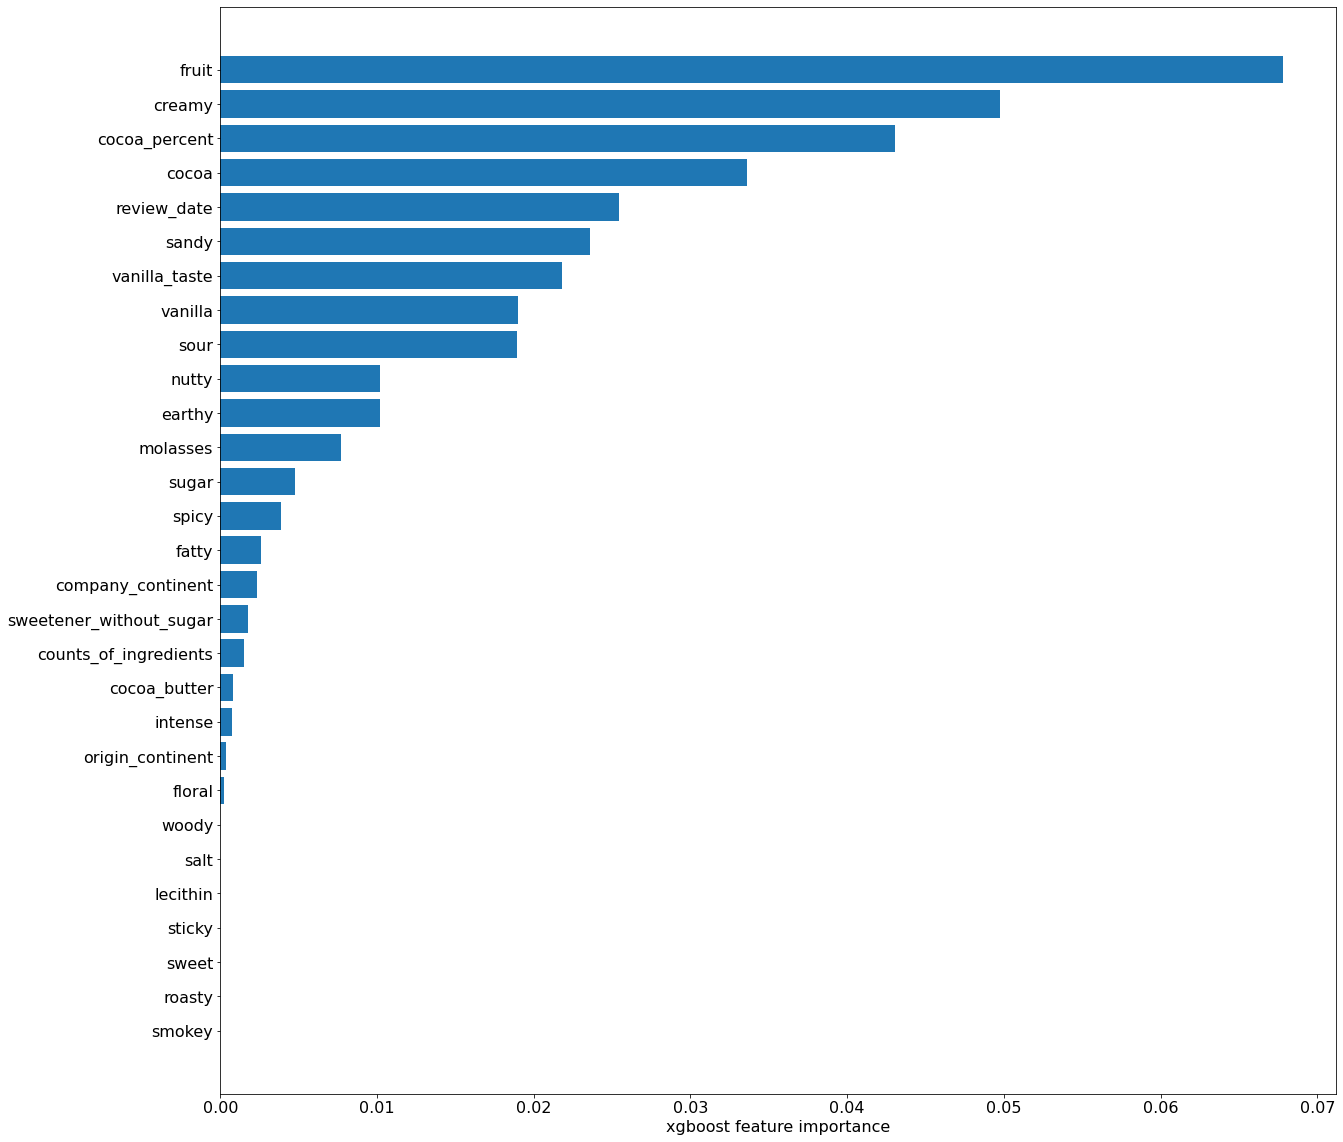

In [17]:
# feature importance from xgboost

importance = permutation_importance(final_xgb, X, y)

plt.figure(figsize=(20, 20))
sorted_idx = importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], importance.importances_mean[sorted_idx])
plt.xlabel('xgboost feature importance', fontsize = 16)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.show()

In [18]:
# make predictions on the test set

rf_pred = final_rf.predict(X_test)
xgb_pred = final_xgb.predict(X_test)
lg_pred = final_lg.predict(X_test)

In [19]:
# MAE of predictions by three models

df_MAE = pd.DataFrame(data = {'MAE of predictions' : [metrics.mean_absolute_error(y_test, rf_pred),
                                                      metrics.mean_absolute_error(y_test, xgb_pred),
                                                      metrics.mean_absolute_error(y_test, lg_pred)]},
                      index = ['Random forest', 'XGBoost', 'LightGBM'])
                      
df_MAE

,MAE of predictions
Random forest,0.2765
XGBoost,0.2533
LightGBM,0.2545
